# 客户流失预警分析

In [13]:
library(tidyverse)
library(gridExtra)
library(pROC)

## 1. 读入训练数据

In [3]:
train.raw<-read.csv("data/sampledata.csv")

## 2. 绘制变量的箱线图

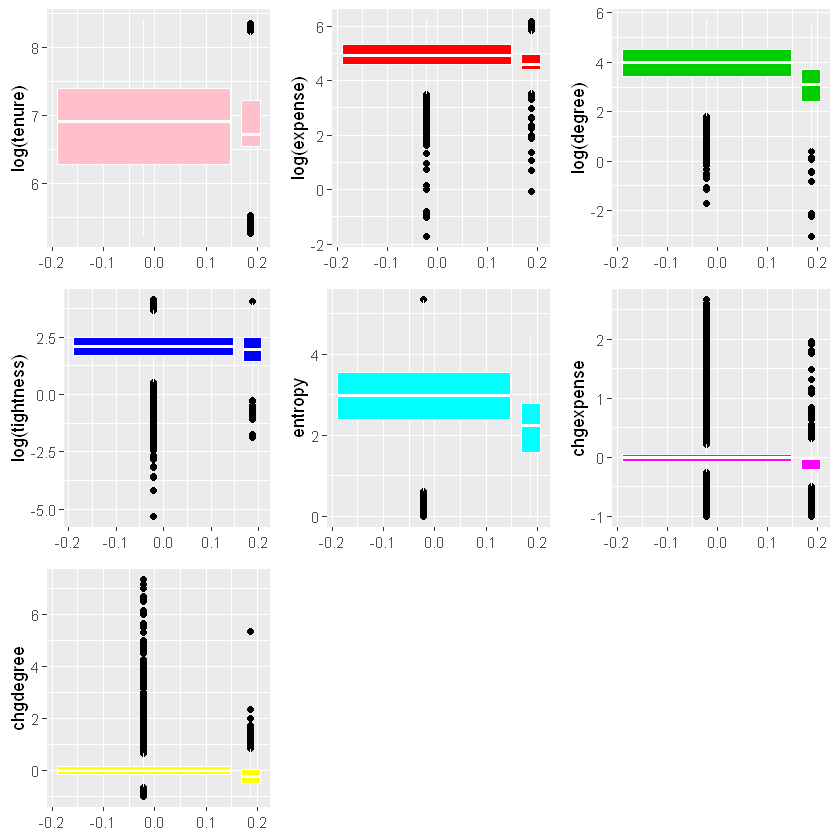

In [4]:
par(mfrow=c(4,2))
plot1<-ggplot(train.raw)+geom_boxplot(aes(group=churn,y=log(tenure)),fill='pink',col='white',outlier.color='black',varwidth=T)
plot2<-ggplot(train.raw)+geom_boxplot(aes(group=churn,y=log(expense)),fill=2,col='white',outlier.color='black',varwidth=T)
plot3<-ggplot(train.raw)+geom_boxplot(aes(group=churn,y=log(degree)),fill=3,col='white',outlier.color='black',varwidth=T)
plot4<-ggplot(train.raw)+geom_boxplot(aes(group=churn,y=log(tightness)),fill=4,col='white',outlier.color='black',varwidth=T)
plot5<-ggplot(train.raw)+geom_boxplot(aes(group=churn,y=entropy),fill=5,col='white',outlier.color='black',varwidth=T)
plot6<-ggplot(train.raw)+geom_boxplot(aes(group=churn,y=chgexpense),fill=6,col='white',outlier.color='black',varwidth=T)
plot7<-ggplot(train.raw)+geom_boxplot(aes(group=churn,y=chgdegree),fill=7,col='white',outlier.color='black',varwidth=T)
grid.arrange(plot1,plot2,plot3,plot4,plot5,plot6,plot7,ncol=3)

## 3. 建立逻辑回归模型

In [5]:
train.scaled<-data.frame(scale(subset(train.raw,select=-c(ID,churn))),churn=train.raw$churn)
model<-glm(data=train.scaled,churn~tenure+expense+degree+tightness+entropy+chgexpense+chgdegree,family=binomial(link='logit'))

In [6]:
summary(model)


Call:
glm(formula = churn ~ tenure + expense + degree + tightness + 
    entropy + chgexpense + chgdegree, family = binomial(link = "logit"), 
    data = train.scaled)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8909  -0.1748  -0.1198  -0.0748   4.2072  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.05338    0.07212 -70.067  < 2e-16 ***
tenure      -0.24767    0.06070  -4.080 4.50e-05 ***
expense     -0.29229    0.05904  -4.951 7.39e-07 ***
degree      -0.73751    0.13172  -5.599 2.15e-08 ***
tightness   -0.22660    0.04254  -5.327 9.99e-08 ***
entropy     -0.35176    0.07208  -4.880 1.06e-06 ***
chgexpense  -0.16071    0.04893  -3.284  0.00102 ** 
chgdegree   -0.38279    0.05208  -7.349 1.99e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6475.5  on 48284  degrees of freedom
Residual deviance: 5757.6  on 48277  degree

从回归系数进行分析，我们发现用户的流失与所有自变量都有较强的关系，在网时长越长、当月话费越高、个体通话数量越多、联系强度越大、个体信息熵越大、个体度的上升以及个体花费的上升都意味着这个用户不容易流失。

## 4. 模型预测

#### 训练集

In [7]:
train.pred<-predict(model,train.scaled,type='response')
head(train.pred)

1           2           3           4           5           6 
0.004999719 0.010796015 0.003467837 0.008023648 0.002977289 0.001469916

#### 测试集

In [10]:
test.raw<-read.csv('data/preddata.csv')
test.scaled<-data.frame(scale(subset(test.raw,select=-c(ID,churn))),churn=test.raw$churn)
test.pred<-predict(model,newdata=test.scaled,type='response')
head(test.pred)

1            2            3            4            5            6 
0.0332009167 0.0062862747 0.0085627283 0.0006695617 0.0073670728 0.0037128759

## 5. ROC曲线

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


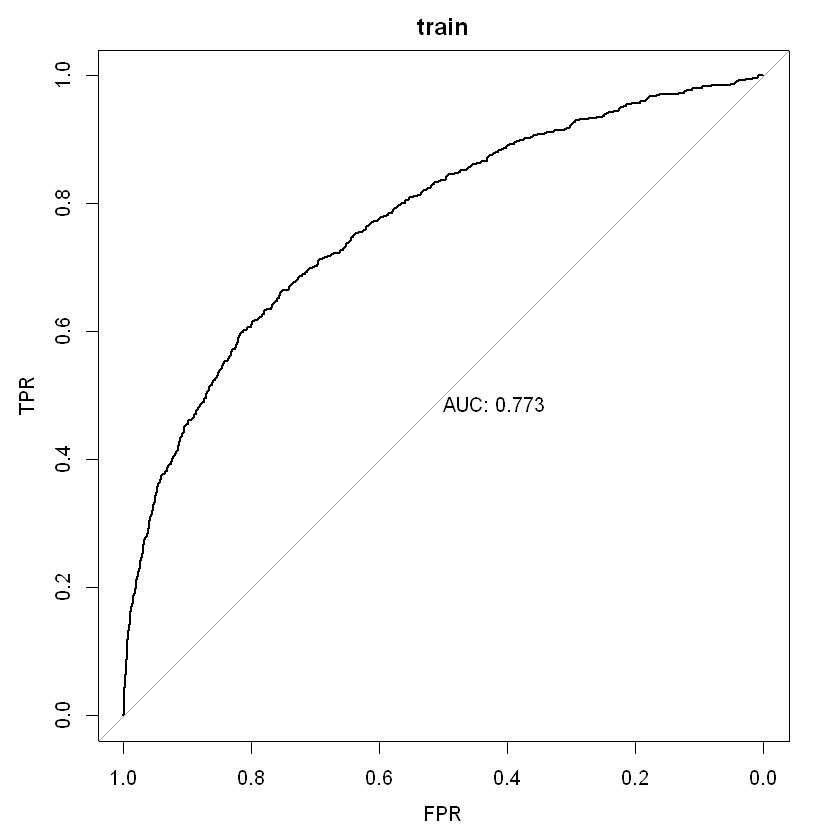

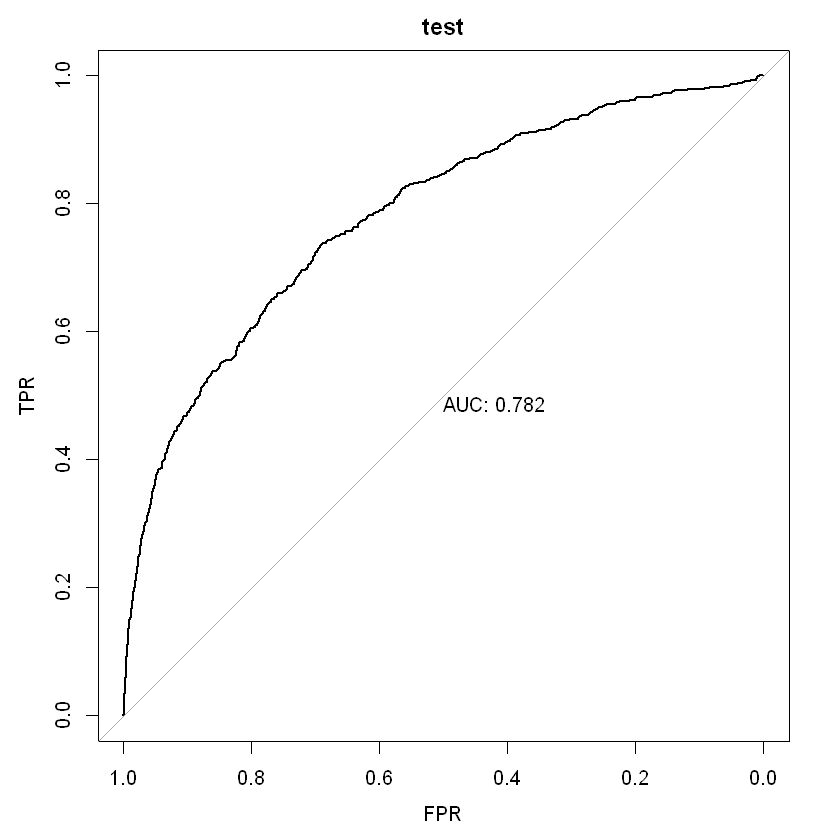

In [12]:
# par(mfrow=c(2,2))
plot.roc(train.raw$churn,train.pred,xlab = "FPR", ylab = "TPR",print.auc=TRUE,main='train')
plot.roc(test.raw$churn,test.pred,xlab = "FPR", ylab = "TPR",print.auc=TRUE,main='test')

我们可以看到，$\mathrm{AUC}_{Test}=0.782$。也就是说，给出一个正例和反例，78.2%的情况下有$f(x^+)>f(x^-)$